In [304]:
import torch
import jieba
import random

import numpy as np

from data import Data
from torch import nn, optim
from datetime import datetime
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset

In [305]:
# Set random seed.
random_seed = 0

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [306]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda:0"

print(device)

cuda:0


In [307]:
classes = {
    0: "牡羊",
    1: "金牛",
    2: "雙子",
    3: "巨蠍",
    4: "獅子",
    5: "處女",
    6: "天秤",
    7: "天蠍",
    8: "射手",
    9: "魔羯",
    10: "水瓶",
    11: "雙魚",
}

In [308]:
raw = {i: open(f"./dataset/{classes[i]}.txt", encoding="utf-8").read() for i in range(12)}
data = Data(data=raw, padding_length=32)

train_raw = data.get("data")

Cleaning completed.
ToDataset completed.
Argumantation completed.
Tokenlization completed.
Padding completed.
Token2id completed.
Process completed.


In [309]:
len(train_raw)

6327

In [310]:
train_raw[0]

[[2187,
  3206,
  1291,
  4599,
  3027,
  2519,
  1688,
  1986,
  5219,
  4678,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774,
  2774],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [311]:
class CreateDataset(Dataset):
    def __init__(self, data: list, label: list):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        return torch.tensor(self.data[index]), torch.tensor(self.label[index], dtype=torch.float)

    def __len__(self):
        return len(self.label)

In [312]:
d, l = [], []

for i, j in train_raw:
    d.append(i); l.append(j)

train_ds = CreateDataset(d, l)

In [313]:
train_ds[1]

(tensor([2187, 3206, 1291, 4599, 3027, 2519, 1688, 1986, 5219, 4678, 2774, 2774,
         2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774,
         2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [314]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

In [315]:
class Model(nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.embedding = nn.Embedding(data.get("token_len"), 64)
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=256,
            num_layers=4,
            dropout=0.5,
            batch_first=True,
            bidirectional=True
        )
        self.linear = nn.Linear(16384, 12)

    def forward(self, x: torch.Tensor):
        x = self.embedding(x)
        x, _ = self.lstm(x)

        return x[:, :, :256] + x[:, :, :256]

        x = x.reshape(x.size(0), -1)

        x = self.linear(x)

        return x

In [316]:
class Attn(nn.Module):
    def __init__(self, h_dim):
        super(Attn, self).__init__()
        self.h_dim = h_dim
        self.main = nn.Sequential(
            nn.Linear(h_dim, 24),
            nn.ReLU(True),
            nn.Linear(24,1)
        )

    def forward(self, encoder_outputs):
        b_size = encoder_outputs.size(0)
        attn_ene = self.main(encoder_outputs.reshape(-1, self.h_dim)) # (b, s, h) -> (b * s, 1)
        return torch.softmax(attn_ene.reshape(b_size, -1), dim=1).unsqueeze(2) # (b*s, 1) -> (b, s, 1)

In [317]:
class AttentionClassifier(nn.Module):
    def __init__(self, h_dim, c_num):
        super(AttentionClassifier, self).__init__()
        self.attn = Attn(h_dim)
        self.main = nn.Linear(h_dim, c_num)


    def forward(self, encoder_outputs):
        attns = self.attn(encoder_outputs) #(b, s, 1)
        feats = (encoder_outputs * attns).sum(dim=1) # (b, s, h) -> (b, h)
        return torch.log_softmax(self.main(feats),dim=1), attns

In [318]:
model = Model().to(device=device)
classifier = AttentionClassifier(256, 12).to(device=device)

In [319]:
epochs = 30
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss()

In [320]:
# Traning history data.
train_accuracy_h = []
train_loss_h = []
validate_accuracy_h = []

In [321]:
def train(epochs: int, model: nn.Module, optimizer: optim.Optimizer, loss: nn.CrossEntropyLoss, dataloader: DataLoader):
    # Set model to training mode.
    model.train()
    classifier.train()

    for epoch in range(epochs):

        train_accuracy = 0
        train_loss = 0
        train_total = 0
        train_process = 0
        train_time = datetime.now().timestamp()

        for texts, labels in dataloader:
            texts: torch.Tensor
            labels: torch.Tensor

            texts = texts.to(device)
            labels = labels.to(device)

            outputs: torch.Tensor = model(texts)
            outputs, atten = classifier(outputs)
            losses: torch.Tensor = loss(outputs, labels)

            # optimizer.zero_grad()
            for param in model.parameters(): param.grad = None

            # Backpropagation.
            losses.backward()

            # Update parameters.
            optimizer.step()

            _, predict = torch.max(outputs, 1)
            train_accuracy += sum([labels[i][predict[i]] == 1 for i in range(len(predict))])
            train_loss += losses.item()
            train_total += labels.shape[0]
            train_process += 1

            print(
                f"{datetime.now().strftime('%Y/%m/%d %H:%M:%S')} "
                f"Epoch: {epoch:03d} "
                f"Time: {datetime.now().timestamp() - train_time:.2f} "
                f"Process: {train_process / len(dataloader) * 100:.2f}% "
                f"Accuracy: {train_accuracy / train_total * 100:.2f}% "
                f"Loss: {train_loss:.3f}",
                end="\r"
            )

        train_accuracy_h.append(train_accuracy / train_total * 100)
        train_loss_h.append(train_loss)

        print()

        # Early stop.
        if train_accuracy / train_total > 0.99:
            print("Early stopped.")
            break

    # Set model to evaluation mode.
    model.eval()
    classifier.eval()

In [322]:
train(epochs=epochs, model=model, optimizer=optimizer, loss=loss, dataloader=train_dl)

2024/04/01 13:48:00 Epoch: 000 Time: 14.58 Process: 100.00% Accuracy: 10.23% Loss: 1962.374
2024/04/01 13:48:14 Epoch: 001 Time: 14.48 Process: 100.00% Accuracy: 10.83% Loss: 1957.285
2024/04/01 13:48:29 Epoch: 002 Time: 14.38 Process: 100.00% Accuracy: 11.77% Loss: 1953.651
2024/04/01 13:48:44 Epoch: 003 Time: 15.03 Process: 100.00% Accuracy: 12.71% Loss: 1949.043
2024/04/01 13:48:58 Epoch: 004 Time: 14.26 Process: 100.00% Accuracy: 14.27% Loss: 1927.798
2024/04/01 13:49:12 Epoch: 005 Time: 14.31 Process: 100.00% Accuracy: 16.72% Loss: 1879.079
2024/04/01 13:49:26 Epoch: 006 Time: 14.24 Process: 100.00% Accuracy: 21.59% Loss: 1781.803
2024/04/01 13:49:41 Epoch: 007 Time: 14.38 Process: 100.00% Accuracy: 26.81% Loss: 1672.013
2024/04/01 13:49:55 Epoch: 008 Time: 14.25 Process: 100.00% Accuracy: 31.04% Loss: 1576.924
2024/04/01 13:50:10 Epoch: 009 Time: 14.51 Process: 100.00% Accuracy: 35.50% Loss: 1481.259
2024/04/01 13:50:24 Epoch: 010 Time: 14.34 Process: 100.00% Accuracy: 41.82% Los

In [323]:
for i, j in train_dl:
    print(i)
    print(model(i.to(device)))
    print(j)
    break

tensor([[3478, 4316, 1468, 3219, 1986, 2474, 5211, 1283, 4316, 2061, 1717, 4678,
         2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774,
         2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774],
        [4264, 1986, 3749, 1283, 4248, 4647, 1304, 5211, 2043, 1823,    4, 1283,
         1207, 1555, 1892, 4678, 2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774,
         2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774],
        [1612, 5211, 3187, 1283, 2988, 4042,  755, 5433, 1516, 4987, 5047, 5211,
         2117, 3479, 5433, 3685, 1986, 4940, 4678, 2774, 2774, 2774, 2774, 2774,
         2774, 2774, 2774, 2774, 2774, 2774, 2774, 2774],
        [4985, 5210, 1833, 1986, 5206, 4079, 5232, 3025, 2612, 5211, 2001, 3454,
         2148,  816, 1986, 3998, 5232, 2348, 5211, 4554, 4630,   61, 2164, 5320,
         2261, 3957, 4678, 2774, 2774, 2774, 2774, 2774],
        [ 979, 4264, 1986, 4418, 5211, 4562,  487, 1264, 4136, 4857, 1986, 5330,
          862, 5211, 3449, 2817, 2935, 

In [586]:
testset = [
    "勇敢無畏，充滿了活力和冒險精神，他們喜歡追求挑戰，敢於冒險，常常是行動派的領導者。",
    "穩重可靠，以堅韌的意志力和耐心著稱，他們注重安全和舒適，並對物質生活有著強烈的執著。",
    "機智聰明，好奇心旺盛，喜歡交際和表達自己，具有多才多藝的特質，常常充滿了靈活的思維和活力。",
    "情感豐富，善解人意，對家庭和親密關係非常重視，他們總是充滿了溫柔和關懷，是很好的傾聽者和支持者。",
    "自信大方，追求著成為焦點的慾望，他們充滿了熱情和活力，喜歡引領和影響身邊的人，時常展現出優越感和領導能力。",
    "細心謹慎，追求完美，他們善於分析和解決問題，注重細節和有組織性，常常是值得信賴的夥伴和顧問。",
    "追求和諧，優雅而公正，他們注重平衡和公平，善於溝通協調，是很好的調解者和中介者。",
    "神秘內斂，充滿了熱情和直覺，他們擁有強烈的意志力和洞察力，常常是充滿挑戰性和魅力的個體。",
    "自由奔放，熱愛冒險和探索，他們追求著廣闊的視野和新鮮的體驗，時常充滿了樂觀和幽默。",
    "勤奮負責，追求事業成功和社會地位，他們具有堅毅的意志力和耐心，常常是穩健和實際的決策者。",
    "獨立思考，充滿了理想主義和創意，他們追求著獨特的生活方式和社會價值觀，常常是前衛和不拘一格的個體。",
    "敏感善良，充滿了同情心和想像力，他們常常是理想主義者和夢想家，追求著內心的情感和精神實踐。",
    "勇敢無畏，充滿活力，喜歡追求挑戰，常常是行動派的領導者。",
    "穩重可靠，堅韌耐心，注重安全舒適，對物質生活有強烈執著。",
    "機智聰明，好奇心旺盛，善於交際表達，充滿靈活思維和活力。",
    "情感豐富，善解人意，重視家庭和親密關係，溫柔關懷，傾聽支持者。",
    "自信大方，追求成為焦點，充滿熱情活力，喜歡引領影響身邊的人。",
    "細心謹慎，追求完美，善於分析解決問題，注重細節有組織性。",
    "追求和諧，優雅公正，注重平衡公平，善於溝通協調。",
    "神秘內斂，熱情直覺，意志力洞察力強，充滿挑戰性和魅力。",
    "自由奔放，熱愛冒險探索，追求廣闊視野和新鮮體驗，樂觀幽默。",
    "勤奮負責，追求事業成功社會地位，具堅毅意志力和耐心，穩健決策者。",
    "獨立思考，理想主義創意，追求獨特生活方式和價值觀，前衛不拘一格。",
    "敏感善良，同情心想像力豐富，理想主義夢想家，追求內心情感精神實踐。",
    "勇敢果敢，充滿活力，愛冒險。",
    "穩重堅定，堅持自我價值觀。",
    "靈活機智，善於溝通交際。",
    "情感豐富，家庭意識強。",
    "自信領導，熱情奔放。",
    "細心謹慎，追求完美。",
    "追求和諧，公正公平。",
    "神秘敏感，探索深度。",
    "自由探險，樂觀向上。",
    "勤奮穩健，追求成功。",
    "獨立創新，理想主義者。",
    "敏感浪漫，夢想家。",
]

answare = [
    '牡羊', '金牛', '雙子', '巨蠍', '獅子', '處女', '天秤', '天蠍', '射手', '魔羯', '水瓶', '雙魚',
    '牡羊', '金牛', '雙子', '巨蠍', '獅子', '處女', '天秤', '天蠍', '射手', '魔羯', '水瓶', '雙魚',
    '牡羊', '金牛', '雙子', '巨蠍', '獅子', '處女', '天秤', '天蠍', '射手', '魔羯', '水瓶', '雙魚',
]

In [587]:
def process(testset: list) -> torch.Tensor:
    result = []

    for line in testset:
        temp = jieba.lcut(line)
        temp = temp + ["<PAD>"] * (32 - len(temp))
        temp = [data.w2i[x] if x in data.w2i else data.w2i["<PAD>"] for x in temp][:32]
        result.append(temp)

    return torch.tensor(result)

In [588]:
test = process(testset)

In [589]:
model.eval()
classifier.eval()

AttentionClassifier(
  (attn): Attn(
    (main): Sequential(
      (0): Linear(in_features=256, out_features=24, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=24, out_features=1, bias=True)
    )
  )
  (main): Linear(in_features=256, out_features=12, bias=True)
)

In [590]:
result = model(test.to(device))
result, atten = classifier(result)
print(result)

tensor([[-1.3118e-03, -8.5307e+00, -8.7041e+00, -1.0674e+01, -1.0956e+01,
         -1.1292e+01, -9.7097e+00, -8.9563e+00, -8.4886e+00, -1.1470e+01,
         -8.0316e+00, -8.7175e+00],
        [-6.1061e+00, -3.8916e+00, -9.0758e+00, -5.2224e+00, -9.0102e+00,
         -6.7115e+00, -8.1034e+00, -8.5225e+00, -5.4397e+00, -3.7927e-02,
         -5.8858e+00, -9.1551e+00],
        [-7.7672e+00, -6.9246e+00, -5.6723e-01, -8.1303e+00, -8.7446e-01,
         -5.0040e+00, -6.6389e+00, -7.2825e+00, -6.1745e+00, -7.2847e+00,
         -6.6214e+00, -6.6369e+00],
        [-7.1063e+00, -5.8245e+00, -7.7320e+00, -2.9614e-02, -8.9680e+00,
         -5.3675e+00, -5.6477e+00, -7.2756e+00, -6.9202e+00, -4.3879e+00,
         -6.2086e+00, -7.5436e+00],
        [-1.6927e+00, -3.8456e+00, -3.9861e+00, -4.8882e+00, -3.5477e+00,
         -4.8824e+00, -6.5436e+00, -6.6160e-01, -1.6271e+00, -6.1652e+00,
         -4.8146e+00, -4.8335e+00],
        [-7.6262e+00, -3.9389e-02, -8.7388e+00, -8.2527e+00, -8.7355e+00,
      

In [591]:
result = result.tolist()

In [592]:
# Normolization
results = []

for i in range(len(result)):
    temp = result[i]
    temp = [x - min(temp) for x in temp]
    temp = [x / max(temp) for x in temp]
    temp = [round(x, 3) for x in temp]

    results.append(temp)

In [593]:
count = 0

for i, r in enumerate(results):
    t = classes[int(torch.argmax(torch.tensor(r)))]
    if t == answare[i]:
        count += 1
        print(t + "✅")
    else:
        print(t + " <- " + answare[i])

print(f"Correct: {count} ({(count / len(answare)) * 100 :.2f}%)")

牡羊✅
魔羯 <- 金牛
雙子✅
巨蠍✅
天蠍 <- 獅子
金牛 <- 處女
天秤✅
天蠍✅
射手✅
魔羯✅
水瓶✅
牡羊 <- 雙魚
牡羊✅
金牛✅
水瓶 <- 雙子
巨蠍✅
射手 <- 獅子
處女✅
天秤✅
天蠍✅
射手✅
魔羯✅
水瓶✅
巨蠍 <- 雙魚
牡羊✅
金牛✅
雙子✅
巨蠍✅
射手 <- 獅子
金牛 <- 處女
天秤✅
天蠍✅
射手✅
金牛 <- 魔羯
水瓶✅
雙魚✅
Correct: 26 (72.22%)


In [594]:
raise

RuntimeError: No active exception to reraise

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ValueError: The number of FixedLocator locations (24), usually from a call to set_ticks, does not match the number of labels (12).

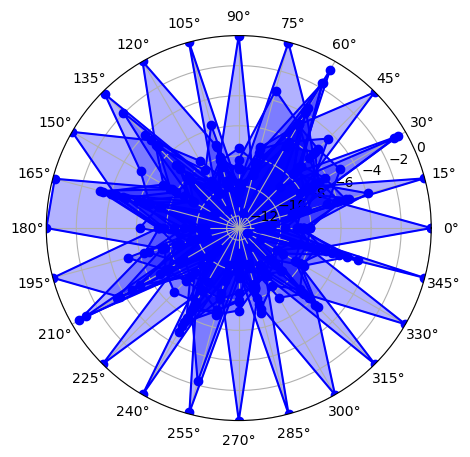

In [ ]:
angles_A = np.linspace(start=0, stop=2*np.pi, num=len(result)+1, endpoint=True)
values_A = np.concatenate((result, [result[0]]))

fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={'projection': 'polar'})
ax.plot(angles_A, values_A, 'o-', color="blue", label="A")

ax.fill(angles_A, values_A, alpha=0.3, color="blue")
ax.set_thetagrids(angles_A[:-1] * 180 / np.pi, range(12), fontsize=15)
ax.set_theta_zero_location('N')

In [ ]:
torch.onnx.export(model, test.to(device=device), 'constellator.onnx')

In [ ]:
import onnx
import onnx.helper

onnx_model = onnx.load('./constellator.onnx')
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch_jit (
  %input.1[INT64, 1x32]
) initializers (
  %embedding.weight[FLOAT, 5470x64]
  %onnx::LSTM_715[FLOAT, 2x2048]
  %onnx::LSTM_716[FLOAT, 2x1024x64]
  %onnx::LSTM_717[FLOAT, 2x1024x256]
  %onnx::LSTM_762[FLOAT, 2x2048]
  %onnx::LSTM_763[FLOAT, 2x1024x512]
  %onnx::LSTM_764[FLOAT, 2x1024x256]
  %onnx::LSTM_809[FLOAT, 2x2048]
  %onnx::LSTM_810[FLOAT, 2x1024x512]
  %onnx::LSTM_811[FLOAT, 2x1024x256]
  %onnx::LSTM_856[FLOAT, 2x2048]
  %onnx::LSTM_857[FLOAT, 2x1024x512]
  %onnx::LSTM_858[FLOAT, 2x1024x256]
) {
  %/embedding/Gather_output_0 = Gather(%embedding.weight, %input.1)
  %/lstm/Transpose_output_0 = Transpose[perm = [1, 0, 2]](%/embedding/Gather_output_0)
  %/lstm/Constant_output_0 = Constant[value = <Tensor>]()
  %/lstm/Constant_1_output_0 = Constant[value = <Tensor>]()
  %/lstm/Shape_output_0 = Shape(%/lstm/Transpose_output_0)
  %/lstm/Constant_2_output_0 = Constant[value = <Scalar Tensor []>]()
  %/lstm/Gather_output_0 = Gather(%/lstm/Shape_output_0, %/lstm/Constant